# Homework - DINO
### Sharif University - Deep Learning Course - Spring 2024

*Instructor:  Dr. Soleymani*

---

*Full Name:* Ehsan Hassanbeygi

*SID:* 402211723

---

In this homework we will learn to use the DINO model.

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* It is important that you read all the code and text blocks carefully, even if you think you are excited to jump into completing the missing codes.
* This notebook is tested with *Google Colab* and *Kaggle* free runtimes and you can used them for testing your code.
* Ensure all cells are executable and perform their intended functions
* You can ask your questions on [Quera Class](https://quera.org/course/16605/)
* Write clear, commented code when necessary.

# Introduction

Listen up, folks! You know how they say dinosaurs are extinct? Well, they lied to us. The DINO model is proof that these ancient beasts are still roaming the earth, but this time, they're here to help us with feature extraction and downstream tasks. Imagine a T-Rex with a fancy deep learning algorithm strapped to its back, stomping around and making sense of all the data in its path.

But wait, it gets better! This dino doesn't just extract features; it does it in a self-supervised manner, which means it's like a kid who learned to tie its own shoelaces without any help from its parents (or, in this case, labeled data). And once it's done extracting those juicy features, it's ready to tackle any downstream task you throw its way, whether it's image classification, object detection, or even predicting the next hot dinosaur-themed movie.

In this homework assignment, we will be utilizing the DINO model to extract meaningful visual features from satellite imagery data. The self-supervised DINO model has proven to be an effective tool for extracting rich representations from visual data without the need for labeled examples during pre-training.

Specifically, we will leverage the DINO model's capabilities to extract visual features from satellite images. These extracted features will then be used to train a classifier on top of the DINO backbone. The goal of this classifier is to predict whether a given satellite image contains solar panels or not.

Moving on to the second part of the assignment, we will explore the transformer attention maps produced by the DINO model. By analyzing these attention maps, we aim to estimate the size of the solar panels present in the positive examples from the dataset.

While not as exhilarating as envisioning a dinosaur with deep learning capabilities, this assignment presents an opportunity to gain hands-on experience with a state-of-the-art self-supervised model and its applications in computer vision tasks. I'm sure you'll find the process insightful and rewarding.

# Installations and imports

As usual, imports are our first step.

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 18.1 MB/s eta 0:00:00


In [3]:
import glob
import torch
import rasterio
import numpy as np
import einops as eo
import random as rnd
import torch.nn as nn
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.colors import Normalize
from torch.utils.data import Dataset, DataLoader

# Dataset

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Move the dataset to this colab session.
# We suggest you add a shortcut from the given file to your own google drive account and then copy the file from that shortcut to here.

# ======================= Your Code =======================
!cp -n /content/drive/MyDrive/SUT_stuff/DL/hw5/uk20K.zip ./
# ======================= Your Code =======================

In [6]:
!unzip -nq uk20K.zip

Let's prepare the train and validation datasets.

In [7]:
def normalize(image, MEAN=[0.485, 0.456, 0.406], STD=[0.485, 0.456, 0.406]):
    image = image / 255
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    return np.moveaxis((np.moveaxis(image, source, dest) - MEAN) / STD, dest, source)


def denormalize(image, MEAN=[0.485, 0.456, 0.406], STD=[0.485, 0.456, 0.406]):
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    image = np.moveaxis((np.moveaxis(image, source, dest) * STD) + MEAN, dest, source)
    return (image * 255).astype(int)


class SolarDataset(Dataset):
    def __init__(self, file_names):
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        path = self.file_names[index]
        x = rasterio.open(self.file_names[index]).read()
        y = (
            torch.tensor(1.0).long()
            if path.endswith("-P.tif")
            else torch.tensor(0.0).long()
        )
        x = normalize(x, MEAN=[0.5, 0.5, 0.5], STD=[0.5, 0.5, 0.5])
        return torch.as_tensor(x.copy()).float(), y, self.file_names[index]

The dataset comprises of .tif image files. The images are labeled based on the presence or absence of solar panels within them. If an image's filename ends with "-P" it indicates a positive label, signifying that the image contains at least one solar panel. Conversely, if the filename ends with "-N" it denotes a negative label, implying that no solar panels are present in the image. However, the dataset does not provide any details regarding the size of the solar panels in the images.

Split the dataset into train and test sets and create the dataloaders.

In [8]:
# ======================= Your Code =======================
from sklearn.model_selection import train_test_split


batch_size = 32
num_workers = 2

file_names = glob.glob("./uk20K_v2/*.tif")
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_ds = SolarDataset(train_files)
val_ds = SolarDataset(val_files)

train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
# ======================= Your Code =======================

print(len(train_dl), len(val_dl))

500 125


# Model definition

This section focuses on defining the models. The first component is a DINO backbone, which serves as a feature extractor. The code for DINO is already written and does not require any modifications. The second component is a classifier head that will be placed on top of the DINO features. The init function for this model has been provided, and your task is to complete the forward method.

In [9]:
class DinoBackbone(nn.Module):
    def __init__(self, dino_size="small") -> None:
        super().__init__()
        if dino_size == "small":
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg")
            self.d_model = 384
        elif dino_size == "base":
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14_reg")
            self.d_model = 768
        elif dino_size == "giant":
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14_reg")
            self.d_model = 1536

    def forward(self, x):
        x = self.dinov2.forward_features(x)
        cls_token = x["x_norm_clstoken"]
        patch_tokens = x["x_norm_patchtokens"]
        return cls_token, patch_tokens

In [63]:
class TransformerEncoderLinearHead(nn.Module):

    def __init__(self, d_model, output_size) -> None:
        super().__init__()
        self.transformer = nn.TransformerEncoderLayer(d_model, 8, batch_first=True)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x_feats):
        cls_embs, patch_embs = x_feats

        # ==================== Your Code ====================

        combined_embs = torch.cat((cls_embs.unsqueeze(1), patch_embs), dim=1)
        transformer_output = self.transformer(combined_embs)
        cls_output = transformer_output[:, 0, :]  # Get the [CLS] token output
        output = self.fc(cls_output)
        return output

        # ==================== Your Code ====================

    def get_size_estimate(self, x_feats, vis=False, images=None, threshold=0.5):

        # ==================== Your Code ====================

        cls_embs, patch_embs = x_feats
        combined_embs = torch.cat((cls_embs.unsqueeze(1), patch_embs), dim=1)

        _, attn_weights = self.transformer.self_attn(
            combined_embs, combined_embs, combined_embs, need_weights=True
        )

        cls_attention = attn_weights[:, 0, 1:].view(-1, 16, 16)

        upsampled_attention = F.interpolate(
            cls_attention.unsqueeze(1),
            scale_factor=14,
            mode="nearest",
        ).squeeze(1)

        flat_attention = upsampled_attention.view(upsampled_attention.size(0), -1)
        attention_min = flat_attention.min(dim=1, keepdim=True)[0]
        attention_max = flat_attention.max(dim=1, keepdim=True)[0]
        reshaped_min = attention_min.view(-1, 1, 1)
        reshaped_max = attention_max.view(-1, 1, 1)
        normalized_attention = (upsampled_attention - reshaped_min) / (
            reshaped_max - reshaped_min
        )

        attention = (normalized_attention > threshold).float().detach().cpu().numpy()
        # ==================== Your Code ====================

        h, w = attention.shape[-2:]
        visualization_images = []
        if vis:
            for i in range(images.shape[0]):
                img = images[i].detach().cpu().numpy().transpose((1, 2, 0))
                normalized_img = Normalize(vmin=img.min(), vmax=img.max())(img)

                reds = plt.cm.Reds(attention[i])
                alpha_max_value = 1.00
                gamma = 0.5

                rgba_img = np.zeros((h, w, 4))
                rgba_img[..., :3] = normalized_img
                rgba_img[..., 3] = 1

                rgba_mask = np.zeros((h, w, 4))
                rgba_mask[..., :3] = reds[..., :3]
                rgba_mask[..., 3] = np.power(attention[i], gamma) * alpha_max_value

                rgba_all = np.zeros((h, 2 * w, 4))
                rgba_all[:, :w, :] = rgba_img
                rgba_all[:, w:, :] = rgba_mask

                visualization_images.append(rgba_all)

        counts = attention.sum((1, 2))
        return counts, visualization_images

# Train

Now initialize the model, define the optimizer and loss function and train the classifier model. Train your model for 2 epochs (this should be pretty fast). Pay attention that your code produces similar output as the one in the notebook so that training loss and validation accuracy are reported.

In [64]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

backbone = DinoBackbone(dino_size="small")
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head = head.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [65]:
lr = 0.001
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [13]:
num_epochs = 2

# ==================== Your Code ====================
for epoch in range(num_epochs):
    running_loss = 0
    head.train()
    for iter, (X, y, _) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            X_features = backbone(X)
        y_hat = head(X_features)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        if iter % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{iter}], Training Loss: {loss.item():.4f}"
            )

    running_loss, n_correct = 0, 0
    head.eval()
    for X, y, _ in val_dl:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            X_features = backbone(X)
            y_hat = head(X_features)
            loss = criterion(y_hat, y)
            y_pred = y_hat.argmax(dim=1)

            running_loss += loss.item()
            n_correct += torch.sum(torch.eq(y_pred, y))

    val_loss = running_loss / len(val_dl)
    acc = n_correct / len(val_dl.dataset)
    print(f"Validation Loss: {loss:.4f} -- Validation Accuracy: {acc:.4f}")
# ==================== Your Code ====================

torch.save(head.state_dict(), "final_model.pth")

Epoch [1/2], Step [0], Training Loss: 0.7318
Epoch [1/2], Step [10], Training Loss: 0.3573
Epoch [1/2], Step [20], Training Loss: 0.3602
Epoch [1/2], Step [30], Training Loss: 0.2808
Epoch [1/2], Step [40], Training Loss: 0.3110
Epoch [1/2], Step [50], Training Loss: 0.2683
Epoch [1/2], Step [60], Training Loss: 0.4301
Epoch [1/2], Step [70], Training Loss: 0.2146
Epoch [1/2], Step [80], Training Loss: 0.0599
Epoch [1/2], Step [90], Training Loss: 0.4033
Epoch [1/2], Step [100], Training Loss: 0.2876
Epoch [1/2], Step [110], Training Loss: 0.3045
Epoch [1/2], Step [120], Training Loss: 0.2418
Epoch [1/2], Step [130], Training Loss: 0.1643
Epoch [1/2], Step [140], Training Loss: 0.1889
Epoch [1/2], Step [150], Training Loss: 0.1774
Epoch [1/2], Step [160], Training Loss: 0.0709
Epoch [1/2], Step [170], Training Loss: 0.2350
Epoch [1/2], Step [180], Training Loss: 0.2666
Epoch [1/2], Step [190], Training Loss: 0.3991
Epoch [1/2], Step [200], Training Loss: 0.2496
Epoch [1/2], Step [210],

In [66]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

backbone = DinoBackbone(dino_size="small")
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head.load_state_dict(torch.load("final_model.pth"))
head = head.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Now go through the validation set and for every image predict whether it contains solar panel or not. Then from all the images that contain solar panels, visualize some that have the large panels and some with the small panels based on your size estimation module. Your outputs should be something like the following. Remeber: you have to look at size estimates only for images that are predicted positive (contain solar panel.) The size estimation module doesn't work for negative images (There are no panels to estimate their size).


Plotting the largest panels:
Size: 1372.0


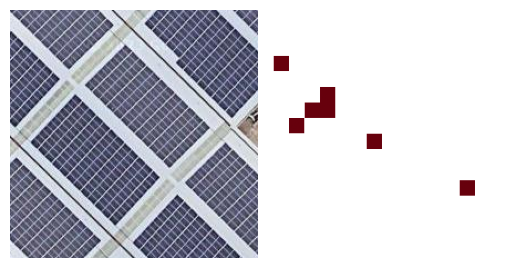


Size: 1372.0


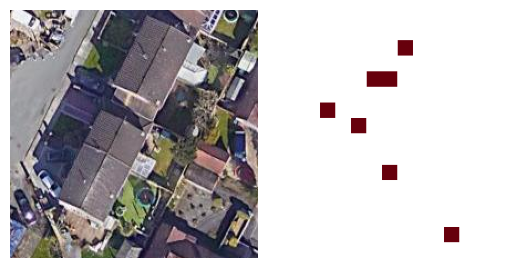


Size: 1372.0


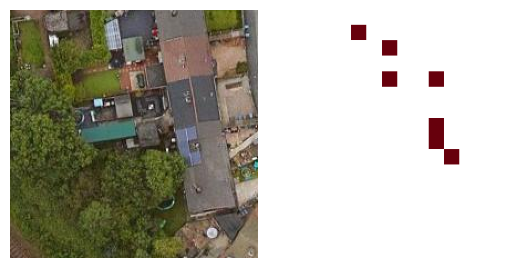


Size: 1372.0


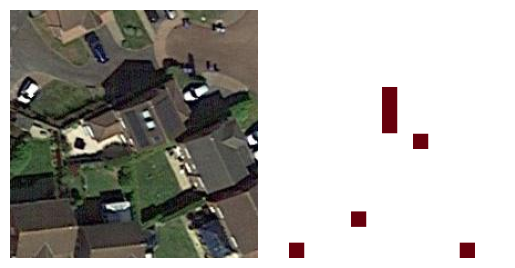


Size: 1568.0


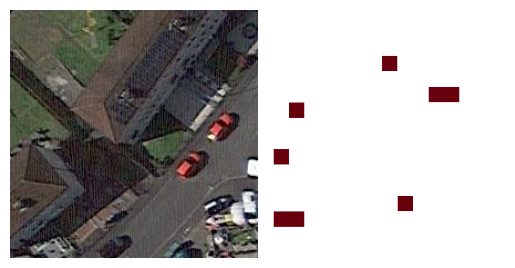



Plotting the smallest panels:
Size: 196.0


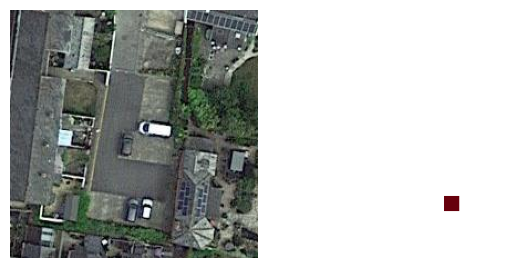


Size: 196.0


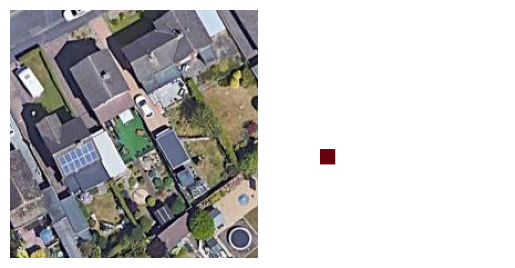


Size: 196.0


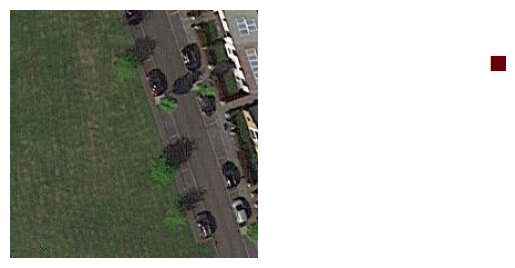


Size: 196.0


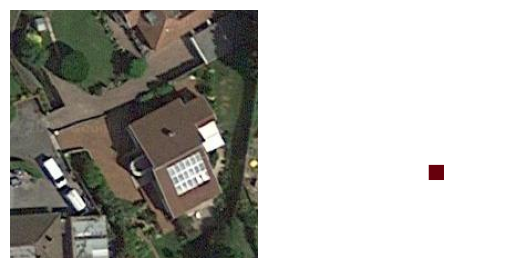


Size: 196.0


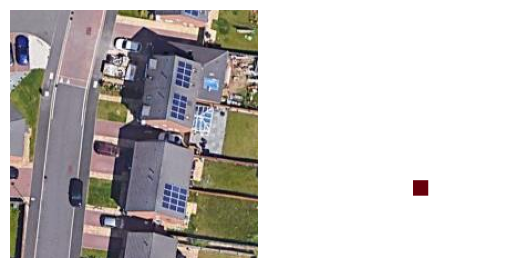

In [67]:
# ======================== Your Code ========================
def update_top_panels(new_panels, largest_panels, smallest_panels):
    for panel in new_panels:
        if panel[0] > largest_panels[0][0]:  # new panel is among top largest panels
            largest_panels[0] = panel
            largest_panels = sorted(largest_panels, key=lambda x: x[0])

        if panel[0] < smallest_panels[0][0]:  # new panel is among top smallest panels
            smallest_panels[0] = panel
            smallest_panels = sorted(smallest_panels, key=lambda x: x[0], reverse=True)

    return largest_panels, smallest_panels


backbone.eval()
head.eval()
with torch.no_grad():
    N_TOP = 5

    largest_panels = [(0, None) for i in range(N_TOP)]
    smallest_panels = [(float("inf"), None) for i in range(N_TOP)]

    for X, _, _ in val_dl:
        X = X.to(device)

        X_features = backbone(X)

        y_pred = head(X_features)
        y_pred = y_pred.argmax(dim=1)
        pos_idc = (y_pred == 1).nonzero().squeeze().tolist()

        sizes, visualizations = head.get_size_estimate(X_features, vis=True, images=X)

        new_panels = zip(
            sizes[pos_idc].tolist(),
            [v for i, v in enumerate(visualizations) if i in pos_idc],
        )
        largest_panels, smallest_panels = update_top_panels(
            new_panels, largest_panels, smallest_panels
        )

    print("\nPlotting the largest panels:")

    for size, visualization in largest_panels:
        print(f"Size: {size}")
        plt.imshow(visualization)
        plt.axis("off")
        plt.show()
        print()

    print("=" * 30)
    print("\nPlotting the smallest panels:")

    for size, visualization in smallest_panels:
        print(f"Size: {size}")
        plt.imshow(visualization)
        plt.axis("off")
        plt.show()
        print()
# ======================== Your Code ========================